In [6]:
# Standard imports
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Specific imports
from sklearn.metrics import (
    r2_score,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.linear_model import LassoCV,RidgeCV, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# pip install scikit-learn xgboost lightgbm

- *Preparação dos dados*

In [23]:
# Carregar dados pré-processados
df = pd.read_csv(r"data\dados_preprocessados_new2.csv",index_col="time",parse_dates=True)

# Visualizar dados
df

,temperature_2m (°C),relative_humidity_2m (%),surface_pressure (hPa),cloud_cover (%),shortwave_radiation (W/m²),boundary_layer_height (m),wind_gusts_10m (m/s),month_sin,month_cos,temperature_2m (°C) - lag - 1,...,boundary_layer_height (m)_rolling_mean_3,boundary_layer_height (m)_rolling_std_3,boundary_layer_height (m)_rolling_mean_12,boundary_layer_height (m)_rolling_std_12,wind_gusts_10m (m/s)_rolling_mean_3,wind_gusts_10m (m/s)_rolling_std_3,wind_gusts_10m (m/s)_rolling_mean_12,wind_gusts_10m (m/s)_rolling_std_12,TARGET,TARGET_CLIMATOLOGY_more_Trend
time,,,,,,,,,,,,,,,,,,,,,
1992-01-01,26.985215,71.795699,986.417876,64.483871,229.033602,814.522849,8.208468,5.000000e-01,8.660254e-01,27.305780,...,929.145311,100.088759,891.512393,207.143965,9.124879,0.808758,8.143679,1.495658,7.448765,16.287192
1992-02-01,25.860920,79.972701,987.421264,68.079023,229.150862,655.495690,6.974425,8.660254e-01,5.000000e-01,26.985215,...,814.555911,159.076755,886.802956,212.177261,8.203437,1.226505,8.147141,1.492646,7.419378,15.652614
1992-03-01,26.377957,77.126344,986.807661,63.270161,231.435484,729.294355,7.066801,1.000000e+00,6.123234e-17,25.860920,...,733.104298,79.582009,891.840479,207.191054,7.416565,0.687362,8.182333,1.458587,7.828768,15.419071
1992-04-01,26.640417,74.563889,986.491806,50.959722,231.348611,751.340278,7.398889,8.660254e-01,-5.000000e-01,26.377957,...,712.043441,50.197030,904.404715,191.931956,7.146705,0.223228,8.306280,1.302972,8.443447,15.961874
1992-05-01,27.561022,63.946237,987.158602,27.849462,234.116935,960.396505,8.446909,5.000000e-01,-8.660254e-01,26.640417,...,813.677046,127.540015,934.026691,167.369690,7.637533,0.720338,8.515745,1.067602,8.500395,16.604292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01,28.195161,64.150538,986.782258,42.395161,269.448925,1013.219086,8.713306,-2.449294e-16,1.000000e+00,27.950972,...,1060.137545,41.053188,937.038295,187.511201,9.234981,0.456537,7.620394,1.801269,7.278215,16.026092
2025-01-01,27.575941,72.633065,986.965188,55.797043,236.379032,780.443548,6.752957,5.000000e-01,8.660254e-01,28.195161,...,961.040323,160.979818,925.917032,192.888861,8.342597,1.440516,7.565118,1.818201,7.478353,15.686582
2025-02-01,27.209673,72.388393,986.508036,62.474702,253.754464,833.772321,6.658780,8.660254e-01,5.000000e-01,27.575941,...,875.811652,121.949136,923.866585,193.800711,7.375014,1.159951,7.562114,1.819799,6.961126,15.073272


- *Análise de features*

In [13]:
# Análise de correlação entre features (heatmap)
# plt.figure(figsize=(12, 9))
# sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
# plt.show()

In [14]:
# Análise de regressão entre features e target
# for col in df.columns:
#     sns.jointplot(x=col,y="TARGET",data=df,kind="reg")

- *Avaliação de modelos candidatos*

In [24]:
tss = TimeSeriesSplit(n_splits=3,test_size=36)
# Dictionary of models
model_configs = {
    # Regularized models
    "RIDGE": make_pipeline(
        StandardScaler(), RidgeCV(scoring="neg_mean_squared_error", cv=tss)
    ),
    "LASSO": make_pipeline(
        StandardScaler(), LassoCV(random_state=42, max_iter=10_000, cv=tss)
    ),
    "ENET": make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            cv=tss, random_state=42, l1_ratio=[0.1, 0.5, 0.9], max_iter=10_000
        ),
    ),
    # Neural networks
    "NN_small": make_pipeline(
        MinMaxScaler(),
        MLPRegressor(
            random_state=42, solver="lbfgs", hidden_layer_sizes=(5,), max_iter=1000
        ),
    ),
    # "NN_large": make_pipeline(
    #     MinMaxScaler(),
    #     MLPRegressor(
    #         random_state=42,
    #         solver="adam",
    #         hidden_layer_sizes=(64, 32),
    #         activation="relu",
    #         learning_rate_init=0.001,
    #         early_stopping=True,
    #         max_iter=2000,
    #     ),
    # ),
    # Ensemble regressors
    "RF": RandomForestRegressor(random_state=42, max_depth=10, max_features="sqrt"),
    "XG": XGBRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
    ),
    "LGBM": LGBMRegressor(
        random_state=42,
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
    ),
}

# Add stacking regressor
# model_configs["STK"] = StackingRegressor(
#     estimators=[
#         ("LASSO", model_configs["LASSO"]),
#         ("RF", model_configs["RF"]),
#         ("XG", model_configs["XG"]),
#     ],
#     final_estimator=RidgeCV(cv=tss, scoring="neg_mean_squared_error"),
# )
# Final models list for iteration
models = list(model_configs.items())

In [8]:
# # Nao esta sendo utilizado
# # Lista com modelos a serem testados e comparados
# models = []

# # Modelo linear
# model = (
#     "LASSO",
#     LassoCV(random_state=42, max_iter=5000, cv=TimeSeriesSplit(n_splits=10,test_size=12))
# )
# models.append(model)

# # Redes Neurais
# model = (
#     "NN",
#     MLPRegressor(random_state=42, hidden_layer_sizes=(5,), solver="lbfgs"),
# )
# models.append(model)

# # Árvore de decisões
# model = (
#     "RF",
#     RandomForestRegressor(random_state=42, max_features="sqrt", n_estimators=100),
# )
# models.append(model)

# # Modelo de Gradiente
# model = ("XGB", XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
# models.append(model)

# model = ("LGB", LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1))
# models.append(model)

# models

In [19]:
335/len(df)

0.8375

In [25]:
# Separar dados em amostras de treino (85%) e de teste (15%)
train_size = 335
train, test = np.split(df, [train_size])

X_train, y_train = train.drop(columns=["TARGET"]), train["TARGET"]
X_test, y_test = test.drop(columns=["TARGET"]), test["TARGET"]

In [26]:
y_test

time
2019-12-01    7.434326
2020-01-01    6.650373
2020-02-01    5.529809
2020-03-01    6.280347
2020-04-01    6.813215
                ...   
2024-12-01    7.278215
2025-01-01    7.478353
2025-02-01    6.961126
2025-03-01    6.991840
2025-04-01    7.866997
Name: TARGET, Length: 65, dtype: float64

In [27]:
# Lista para armazenar os dataframes com as métricas de comparação
comparacao_modelos = []

for nome_modelo, modelo in models:
    pipeline = make_pipeline(MinMaxScaler(), modelo)
    pipeline.fit(X_train, y_train) # treina modelo

    # Realiza previsões para os conjuntos de treino e teste
    previsao_treino = pipeline.predict(X_train)
    previsao_teste = pipeline.predict(X_test)

    # Calcula métricas de desempenho no conjunto de teste
    metricas_teste = {
        "R2" : r2_score(y_test,previsao_teste),
        "RMSE": root_mean_squared_error(y_test,previsao_teste),
        "MAPE (%)": mean_absolute_percentage_error(y_test,previsao_teste)*100,
        "BIAS": (previsao_teste - y_test).mean()
    }

    # Calcula métricas de desempenho no conjunto de treino
    metricas_treino = {
        "R² - Treino": round(r2_score(y_train, previsao_treino), 2),
        "RMSE - Treino": round(root_mean_squared_error(y_train, previsao_treino), 2),
        "MAPE (%) - Treino": round(
            mean_absolute_percentage_error(y_train, previsao_treino) * 100, 2
        ),
        "BIAS - Treino": round((previsao_treino - y_train).mean(), 3),
    }
    # Combina as métricas de treino e teste
    metricas = {**metricas_teste, **metricas_treino}
    df_resultado = pd.DataFrame(metricas,index=[nome_modelo])
    df_resultado.round(2)

    comparacao_modelos.append(df_resultado)

# Concatena os resultados de todos os modelos em um único DataFrame
df_comparacao_final = pd.concat(comparacao_modelos)

# Visualizar resultados
df_comparacao_final.index.name = "Modelos"
df_comparacao_final

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7973
[LightGBM] [Info] Number of data points in the train set: 335, number of used features: 73
[LightGBM] [Info] Start training from score 8.185987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,R2,RMSE,MAPE (%),BIAS,R² - Treino,RMSE - Treino,MAPE (%) - Treino,BIAS - Treino
Modelos,,,,,,,,
RIDGE,0.886832,0.365972,3.951225,0.005491,0.87,0.38,3.78,0.000
LASSO,0.885807,0.367626,3.897886,0.002577,0.86,0.40,3.94,0.000
ENET,0.885720,0.367766,3.908749,0.016964,0.86,0.40,3.92,0.000
NN_small,0.838352,0.437392,4.373550,-0.095022,0.88,0.36,3.60,-0.000
RF,0.851444,0.419305,4.528050,0.135886,0.97,0.18,1.77,-0.008
XG,0.887133,0.365485,3.872952,0.081544,0.98,0.13,1.31,0.001
LGBM,0.876121,0.382899,3.936456,0.070772,1.00,0.01,0.09,-0.000


In [11]:
models[0][1]

LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=12),
        max_iter=5000, random_state=42)

In [12]:
models

[('LASSO',
  LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=12),
          max_iter=5000, random_state=42)),
 ('NN',
  MLPRegressor(hidden_layer_sizes=(5,), random_state=42, solver='lbfgs')),
 ('RF', RandomForestRegressor(max_features='sqrt', random_state=42)),
 ('XGB',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_e

In [28]:
# seleciona modelo para teste
modelo = models[0][1]
nome_modelo = models[0][0]

# Cria um pipeline com normalização MinMaxScaler e o modelo de regressão
pipeline = make_pipeline(MinMaxScaler(), modelo)
pipeline.fit(X_train, y_train) # treina modelo

# Realiza previsões para os conjuntos de treino e teste
previsao_treino = pipeline.predict(X_train)
previsao_teste = pipeline.predict(X_test)

# Calcula métricas de desempenho no conjunto de teste
metricas_teste = {
    "R2" : r2_score(y_test,previsao_teste),
    "RMSE": root_mean_squared_error(y_test,previsao_teste),
    "MAPE (%)": mean_absolute_percentage_error(y_test,previsao_teste)*100,
    "BIAS": (previsao_teste - y_test).mean()
}

# Calcula métricas de desempenho no conjunto de treino
metricas_treino = {
    "R² - Treino": round(r2_score(y_train, previsao_treino), 2),
    "RMSE - Treino": round(root_mean_squared_error(y_train, previsao_treino), 2),
    "MAPE (%) - Treino": round(
        mean_absolute_percentage_error(y_train, previsao_treino) * 100, 2
    ),
    "BIAS - Treino": round((previsao_treino - y_train).mean(), 3),
}
# Combina as métricas de treino e teste
metricas = {**metricas_teste, **metricas_treino}
df_resultado = pd.DataFrame(metricas,index=[nome_modelo])
df_resultado.round(2)

,R2,RMSE,MAPE (%),BIAS,R² - Treino,RMSE - Treino,MAPE (%) - Treino,BIAS - Treino
RIDGE,0.89,0.37,3.95,0.01,0.87,0.38,3.78,0.0


In [29]:
bias = pd.DataFrame(previsao_teste - y_test)
bias.columns = ["BIAS_TESTE"]

bias_treino = pd.DataFrame(previsao_treino - y_train)
bias_treino.columns = ["BIAS_TREINO"]
bias

,BIAS_TESTE
time,
2019-12-01,0.289716
2020-01-01,0.314713
2020-02-01,0.812258
2020-03-01,-0.196779
2020-04-01,0.035156
...,...
2024-12-01,0.601708
2025-01-01,-0.346013
2025-02-01,-0.064509


In [30]:
previsao_teste = pd.DataFrame(previsao_teste,index=bias.index)
previsao_teste.columns = ["TARGET"]
previsao_teste

,TARGET
time,
2019-12-01,7.724042
2020-01-01,6.965086
2020-02-01,6.342068
2020-03-01,6.083568
2020-04-01,6.848371
...,...
2024-12-01,7.879922
2025-01-01,7.132341
2025-02-01,6.896617


In [31]:
# y_test.name = "TARGET" #referente ao mes
df_combined_test = bias.join([previsao_teste,],how="inner")
df_combined_test["TESTE CORRIGIDO"] = df_combined_test["TARGET"] + df_combined_test["BIAS_TESTE"]
df_combined_test["Dif target less predict"] = df_combined_test["TESTE CORRIGIDO"] - df_combined_test["TARGET"]
df_combined_test

,BIAS_TESTE,TARGET,TESTE CORRIGIDO,Dif target less predict
time,,,,
2019-12-01,0.289716,7.724042,8.013759,0.289716
2020-01-01,0.314713,6.965086,7.279800,0.314713
2020-02-01,0.812258,6.342068,7.154326,0.812258
2020-03-01,-0.196779,6.083568,5.886789,-0.196779
2020-04-01,0.035156,6.848371,6.883527,0.035156
...,...,...,...,...
2024-12-01,0.601708,7.879922,8.481630,0.601708
2025-01-01,-0.346013,7.132341,6.786328,-0.346013
2025-02-01,-0.064509,6.896617,6.832108,-0.064509


In [32]:
y_train.name = "TARGET" #referente ao mes
df_combined = bias_treino.join(y_train,how="inner")
df_combined["BIAS CORRIGIDO TREINO"] = df_combined["TARGET"] + df_combined["BIAS_TREINO"]


In [33]:
# Bias treino de mes a mes
bias_treino = pd.DataFrame(previsao_treino - y_train)
bias_treino = bias_treino.groupby(bias_treino.index.month)['TARGET'].mean()
bias_treino = pd.DataFrame(bias_treino)
bias_treino

#Bias test de mes a mes
bias_test = pd.DataFrame(previsao_teste["TARGET"] - y_test)
bias_test = bias_test.groupby(bias_test.index.month)['TARGET'].mean()
bias_test = pd.DataFrame(bias_test)
bias_test

,TARGET
time,
1,-0.138912
2,0.360562
3,0.126582
4,-0.113972
5,-0.012670
6,-0.269035
7,-0.145388
8,-0.023776
9,0.017759


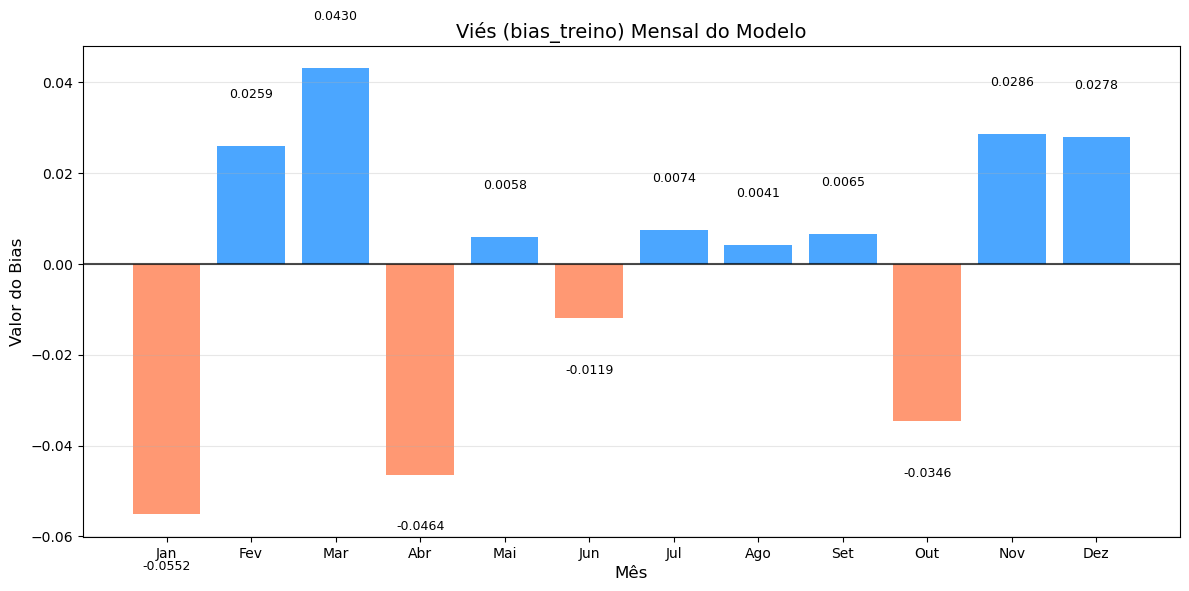

In [34]:
# Nomes dos meses para melhorar a legibilidade
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
         'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Configurações do gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(meses, bias_treino["TARGET"], 
               color=np.where(bias_treino["TARGET"] > 0, 'dodgerblue', 'coral'),
               alpha=0.8)

# Linha de referência em y=0
plt.axhline(y=0, color='k', linestyle='-', alpha=0.7)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    y_pos = height + 0.01 if height > 0 else height - 0.01
    plt.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{height:.4f}', 
             ha='center', va=va, fontsize=9)

# Configurações estéticas
plt.title('Viés (bias_treino) Mensal do Modelo', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Valor do Bias', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

In [23]:
bias

,BIAS_TESTE
time,
2019-12-01,0.623514
2020-01-01,0.463750
2020-02-01,1.108965
2020-03-01,-0.075692
2020-04-01,0.058838
...,...
2024-11-01,-0.008568
2024-12-01,0.761931
2025-01-01,-0.428760


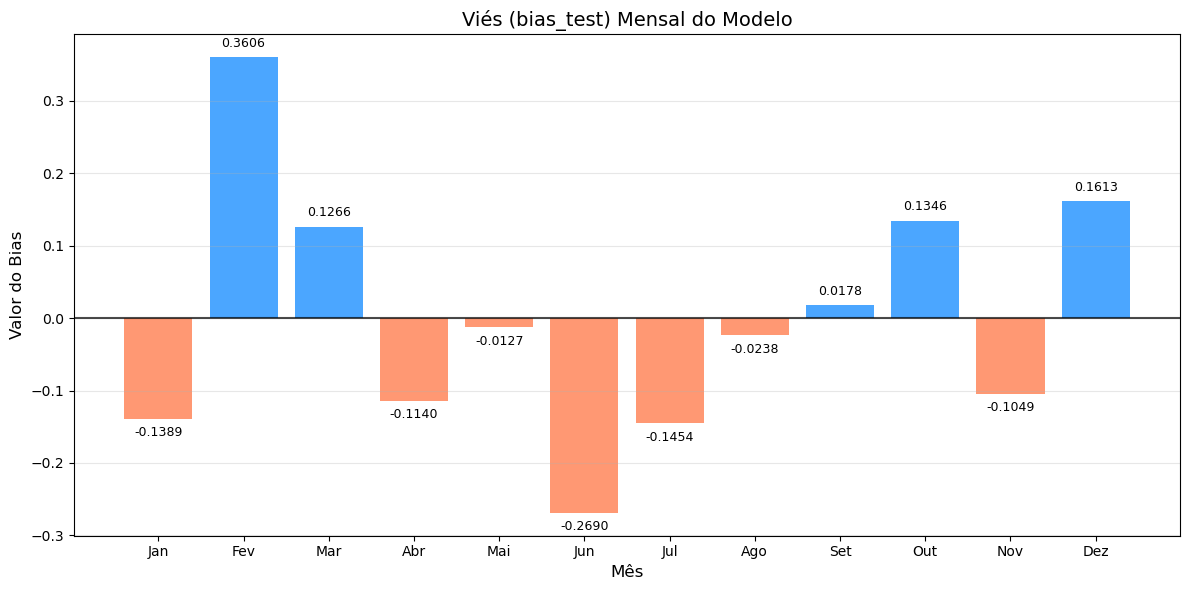

In [35]:
#bias test
# Nomes dos meses para melhorar a legibilidade
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
         'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Configurações do gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(meses, bias_test["TARGET"], 
               color=np.where(bias_test["TARGET"] > 0, 'dodgerblue', 'coral'),
               alpha=0.8)

# Linha de referência em y=0
plt.axhline(y=0, color='k', linestyle='-', alpha=0.7)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    y_pos = height + 0.01 if height > 0 else height - 0.01
    plt.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{height:.4f}', 
             ha='center', va=va, fontsize=9)

# Configurações estéticas
plt.title('Viés (bias_test) Mensal do Modelo', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Valor do Bias', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

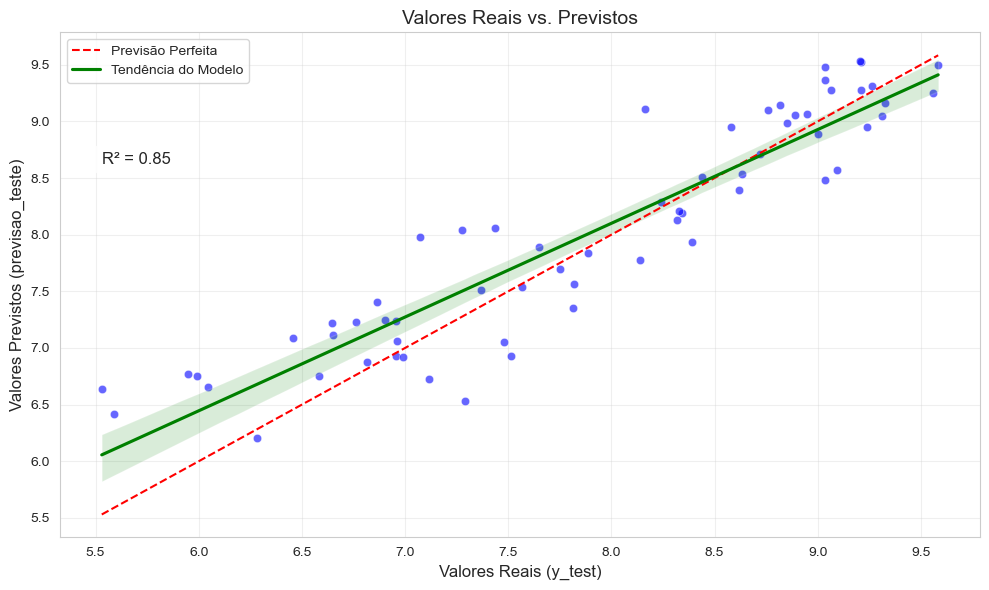

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Gerar previsões para os dados de teste

# Configurar o gráfico
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# previsao_teste = y_prediction ?
# Plotar valores reais vs. previstos
sns.scatterplot(x=y_test, y=previsao_teste, alpha=0.6, color='blue')

# Linha de referência y=x (perfeita previsão)
max_val = max(y_test.max(), previsao_teste.max())
min_val = min(y_test.min(), previsao_teste.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Previsão Perfeita')

# Linha de tendência das previsões
sns.regplot(x=y_test, y=previsao_teste, scatter=False, color='green', label='Tendência do Modelo')

# Configurações estéticas
plt.title('Valores Reais vs. Previstos', fontsize=14)
plt.xlabel('Valores Reais (y_test)', fontsize=12)
plt.ylabel('Valores Previstos (previsao_teste)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Adicionar R² ao gráfico
plt.text(x=min_val, y=max_val*0.9, 
         s=f'R² = {r2_score(y_test, previsao_teste):.2f}', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
previsao_treino

array([7.41208063, 7.00474071, 6.92615383, 7.06867132, 7.4684036 ,
       8.56828676, 9.22419268, 9.5091317 , 9.46502111, 9.0153024 ,
       8.69452057, 8.20305349, 7.40240777, 7.02778328, 7.14601043,
       7.65740081, 8.37781329, 8.77547577, 9.16920419, 9.38821478,
       9.48890264, 9.25324089, 8.79654365, 8.32510721, 7.72431559,
       7.64872142, 7.55639583, 7.84950186, 8.2236228 , 8.73828543,
       9.10238002, 9.25619894, 9.26250909, 9.08012465, 8.67564032,
       8.26587123, 7.15984508, 7.03978667, 6.61912141, 6.87882093,
       7.60871922, 7.87144178, 8.81114868, 9.05513129, 9.36558781,
       9.22313486, 8.76760044, 8.01497012, 7.34006639, 6.40515784,
       6.8799637 , 6.74397934, 7.23510514, 8.20937509, 9.0435091 ,
       9.35752399, 9.43150522, 9.03108965, 8.50472351, 7.89909677,
       7.35126308, 7.13397765, 6.3211857 , 6.36672091, 7.36049935,
       8.63540737, 8.95860313, 9.18662215, 9.46746985, 9.23175274,
       8.55275009, 8.14176044, 7.60239862, 7.56862136, 7.08975

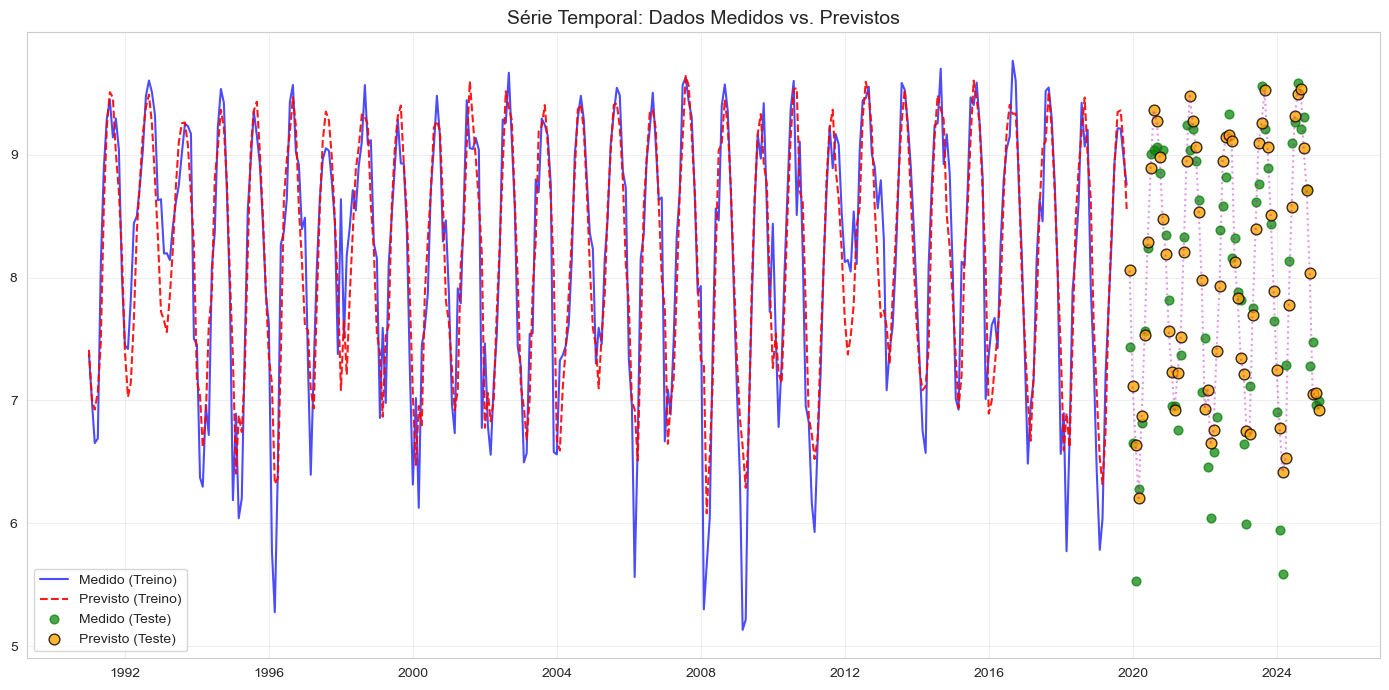

In [ ]:
# Plot sem usar o target corrigido
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# 1. Criar índice temporal para treino e teste
# (Supondo que seu índice seja datetime)
index_train = X_train.index  # Índice do conjunto de treino
index_test = X_test.index    # Índice do conjunto de teste

# 2. Plotar dados medidos de TREINO
plt.plot(index_train, y_train, 'b-', label='Medido (Treino)', alpha=0.7)

# 3. Plotar dados previstos de TREINO
plt.plot(index_train, previsao_treino, 'r--', label='Previsto (Treino)', alpha=0.9)

# 4. Plotar dados medidos de TESTE (pontos reais)
plt.scatter(index_test, y_test, color='green', s=40, label='Medido (Teste)', alpha=0.7)

# 5. Plotar dados previstos de TESTE
plt.scatter(index_test, previsao_teste, color='orange', s=60, 
            edgecolors='k', label='Previsto (Teste)', alpha=0.8)

# 6. Linha de conexão entre previsões de teste
plt.plot(index_test, previsao_teste, 'm:', alpha=0.4)  # Opcional

# 7. Ajustes finais
plt.title('Série Temporal: Dados Medidos vs. Previstos', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

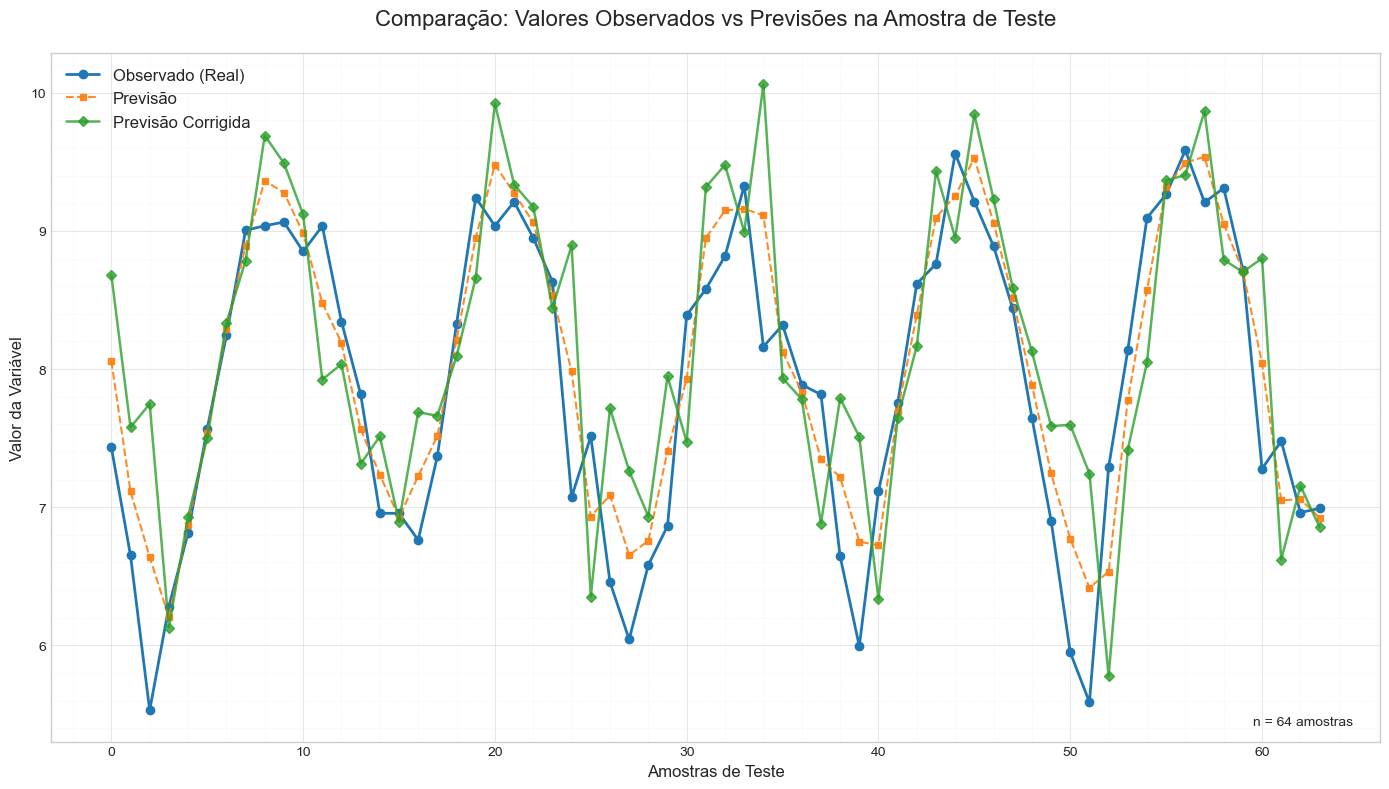

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# Criando o eixo X com índices numéricos
indice = np.arange(len(y_test))

# Plotando as três séries
plt.plot(indice, y_test, 'o-', color='#1f77b4', linewidth=2, markersize=6, label='Observado (Real)')
plt.plot(indice, previsao_teste, 's--', color='#ff7f0e', linewidth=1.5, markersize=5, alpha=0.9, label='Previsão')
plt.plot(indice, df_combined_test["TESTE CORRIGIDO"], 'D-', color='#2ca02c', linewidth=1.8, markersize=5, alpha=0.8, label='Previsão Corrigida')

# Adicionando elementos gráficos
plt.title('Comparação: Valores Observados vs Previsões na Amostra de Teste', fontsize=16, pad=20)
plt.xlabel('Amostras de Teste', fontsize=12)
plt.ylabel('Valor da Variável', fontsize=12)
plt.legend(fontsize=12)

# Configurações do grid
plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.3)
plt.minorticks_on()

# Rótulos do eixo X corrigidos
# plt.xticks(indice, [f'Amostra {i+1}' for i in indice], rotation=45)

# Adicionando anotação de desempenho
plt.annotate(f'n = {len(y_test)} amostras',
             xy=(0.98, 0.02), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

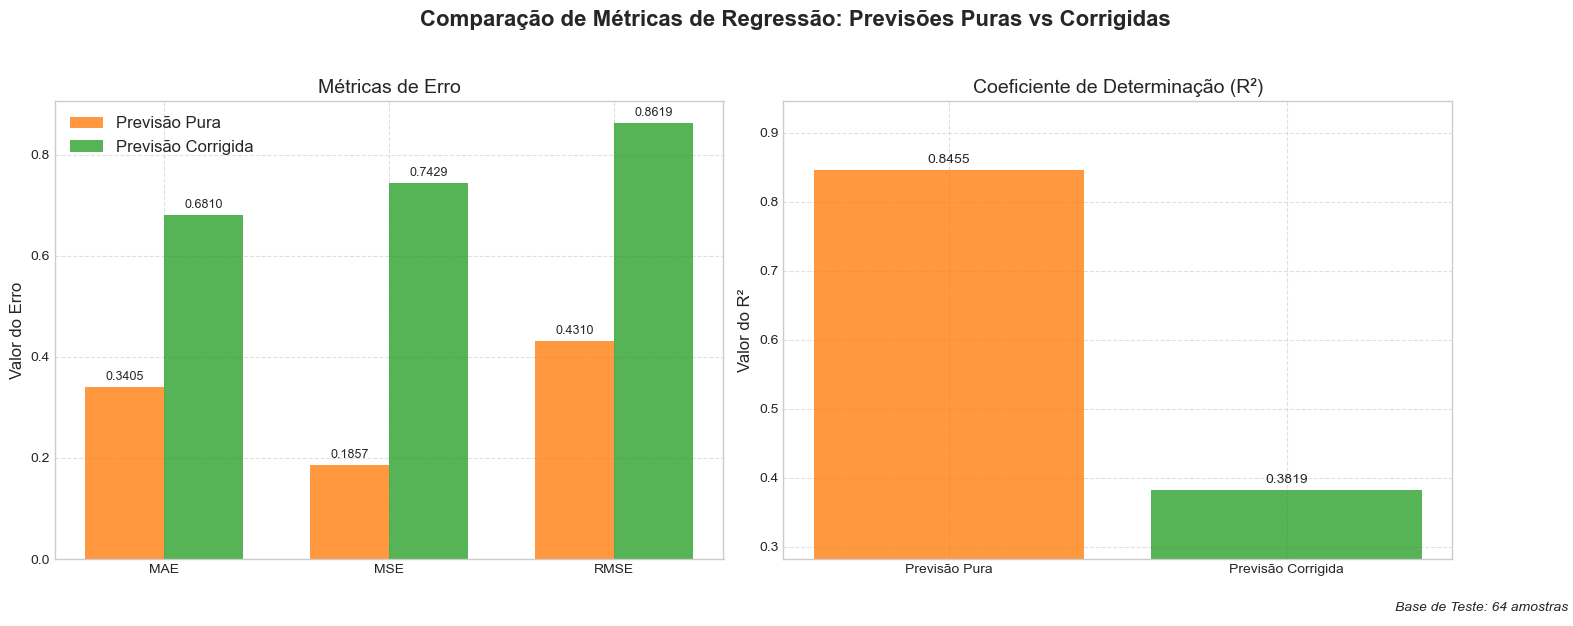

In [40]:
# Calcular métricas para as previsões puras
mae_puro = mean_absolute_error(y_test, previsao_teste)
mse_puro = mean_squared_error(y_test, previsao_teste)
rmse_puro = np.sqrt(mse_puro)
r2_puro = r2_score(y_test, previsao_teste)

# Calcular métricas para as previsões corrigidas
mae_corrigido = mean_absolute_error(y_test, df_combined_test["TESTE CORRIGIDO"])
mse_corrigido = mean_squared_error(y_test, df_combined_test["TESTE CORRIGIDO"])
rmse_corrigido = np.sqrt(mse_corrigido)
r2_corrigido = r2_score(y_test, df_combined_test["TESTE CORRIGIDO"])

# Configurações gerais do gráfico
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparação de Métricas de Regressão: Previsões Puras vs Corrigidas', 
             fontsize=16, fontweight='bold', y=1.03)

# =====================================
# Gráfico 1: Métricas de Erro
# =====================================
metricas_erro = ['MAE', 'MSE', 'RMSE']
valores_puro = [mae_puro, mse_puro, rmse_puro]
valores_corrigido = [mae_corrigido, mse_corrigido, rmse_corrigido]

x = np.arange(len(metricas_erro))
largura = 0.35

barras1 = ax1.bar(x - largura/2, valores_puro, largura, 
                 color='#ff7f0e', alpha=0.8, label='Previsão Pura')
barras2 = ax1.bar(x + largura/2, valores_corrigido, largura, 
                 color='#2ca02c', alpha=0.8, label='Previsão Corrigida')

ax1.set_title('Métricas de Erro', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(metricas_erro)
ax1.set_ylabel('Valor do Erro', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=12)

# Adicionar valores nas barras
for barra in barras1 + barras2:
    altura = barra.get_height()
    ax1.annotate(f'{altura:.4f}',
                xy=(barra.get_x() + barra.get_width()/2, altura),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

# =====================================
# Gráfico 2: Coeficiente R²
# =====================================
modelos = ['Previsão Pura', 'Previsão Corrigida']
r2_valores = [r2_puro, r2_corrigido]
cores = ['#ff7f0e', '#2ca02c']

barras_r2 = ax2.bar(modelos, r2_valores, color=cores, alpha=0.8)
ax2.set_title('Coeficiente de Determinação (R²)', fontsize=14)
ax2.set_ylabel('Valor do R²', fontsize=12)
ax2.set_ylim([min(r2_valores) - 0.1, max(r2_valores) + 0.1])
ax2.grid(True, linestyle='--', alpha=0.6)

# Adicionar valores nas barras
for barra in barras_r2:
    altura = barra.get_height()
    ax2.annotate(f'{altura:.4f}',
                xy=(barra.get_x() + barra.get_width()/2, altura),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

# =====================================
# Elementos Complementares
# =====================================
plt.annotate(f'Base de Teste: {len(y_test)} amostras',
            xy=(0.98, 0.02), xycoords='figure fraction',
            ha='right', va='bottom', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

- *Hiperparametrização*

In [ ]:
# param_grid = {
#     "hidden_layer_sizes": [(5,), (10,), (20,), (10, 5)],
#     "activation": ["relu"],
#     "solver": ["adam", "lbfgs"],
#     "alpha": [1e-4, 1e-3],  # regularização L2
#     "learning_rate": ["constant"],
#     "learning_rate_init": [0.001, 0.01],
# }

# tscv = TimeSeriesSplit(n_splits=10)
# model = MLPRegressor(max_iter=5_000, random_state=42)

# grid = GridSearchCV(
#     model, param_grid, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1
# )